# Loading the Librarys

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
# for data cleaning
import string
import re
# for removing accented and special chracters
import unicodedata
# for stopwords Removal
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
# for calculating Polarity and Subjectivity
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
# function for making ngrams
from nltk.util import ngrams
# load in all the modules we're going to need
import nltk
import collections
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/downsampled_data.csv')

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

def to_three(x):
  if x <= 2: return 0      # 1–2 stars → class 0
  if x == 3: return 1      # 3 stars   → class 1
  return 2                 # 4–5 stars → class 2

df['Score'] = df['Score'].map(to_three)

train_df, test_df = train_test_split(
        df,
        test_size=0.1,
        stratify=df['Score'],
        random_state=42
    )

# Save to CSV
train_df.to_csv('/content/drive/MyDrive/NLP project/train_data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/NLP project/test_data.csv', index=False)

# Print class distributions
print("Train set class distribution:")
print(train_df['Score'].value_counts(normalize=True))

print("\nTest set class distribution:")
print(test_df['Score'].value_counts(normalize=True))

Train set class distribution:
Score
0    0.4
2    0.4
1    0.2
Name: proportion, dtype: float64

Test set class distribution:
Score
0    0.4
2    0.4
1    0.2
Name: proportion, dtype: float64


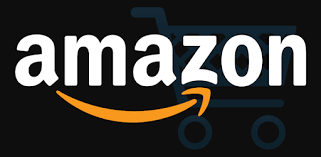

# Load the Dataset


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/NLP project/Reviews.csv')

In [ ]:
# show some of data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,122075,B005LNA5VK,A2K3TU5BIS0RMF,Shelby,0,6,1,1341878400,tastes like grass,I purchased this for the health benefits. Unf...
1,315939,B000EDK3RS,A1SPVNAK9HBTAT,Special Education Teacher,1,5,1,1312243200,Contains MSG!,"I like the taste of this dressing, but realize..."
2,307427,B001D0IZ4O,A2C216Z6CXBCCA,Martha Drummond,1,1,1,1265846400,Hate it.,Drink tasted like water...no chocolate taste a...
3,502262,B004H4LJ8W,A2HWR20S8OKDG,Cali_Girl_In_LA,1,1,1,1347494400,Tastes too sweet,This tastes very sweet compared to other brand...
4,214099,B000TOB8QW,A1XCM5HHAWFFFC,Sharon A. Carroll,0,0,1,1337817600,Strange taste,I ordered 3 jars of this calorie free Alfredo ...


In [ ]:
# show the informatiom of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 9999 non-null   object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [ ]:
df['Text']

,Text
0,I purchased this for the health benefits. Unf...
1,"I like the taste of this dressing, but realize..."
2,Drink tasted like water...no chocolate taste a...
3,This tastes very sweet compared to other brand...
4,I ordered 3 jars of this calorie free Alfredo ...
...,...
9995,This is the best way to cook a roast. Our loc...
9996,"Excellent product, slightly different than any..."
9997,My wife and I enjoy a pot of Green Chai Tea ea...
9998,Our Yorkie loves this stuff. Our vet gave her ...


# Clean the dataset

In [ ]:
# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['Text'] = df['Text'].apply(punctuation_removal)

In [ ]:
# lets make a function to remove Numbers from the reviews
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

df['Text'] = df['Text'].apply(drop_numbers)

In [ ]:
# lets show the Top 10 Reviews after Removal of Punctuations and Numbers
df['Text'].head(10)

,Text
0,I purchased this for the health benefits Unfo...
1,I like the taste of this dressing but realized...
2,Drink tasted like waterno chocolate taste at a...
3,This tastes very sweet compared to other brand...
4,I ordered jars of this calorie free Alfredo s...
5,Our family loves Slim Jims and we eat a lot of...
6,I had been feeding both my year old cats EVO f...
7,Emerald Sea Salt and Pepper Cashews were quite...
8,I was pointed to this item after a Google sear...
9,a hrefhttpwwwamazoncomgpproductBHLHSWMr Kiplin...


In [ ]:
### Removing Accented Characters

"""Accented characters are important elements which are used to signify emphasis on
a particular word during pronunciation or understanding. In some instances,
the accent mark also clarifies the meaning of a word, which might be different without the accent.
While their use in English is largely limited but there are very good chances
that you will come across accented characters/letters in a free text corpus.
Words such as résumé, café, prótest, divorcé,
coördinate, exposé, latté etc"""
# lets create a function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# lets apply the function
df['Text'] = df.apply(lambda x: remove_accented_chars(x['Text']), axis = 1)

In [ ]:
# Create a function to remove special characters
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]'
    return re.sub(pat, ' ', text)

# lets apply this function
df['Text'] = df.apply(lambda x: remove_special_characters(x['Text']), axis = 1)

In [ ]:
# prompt: from nltk.corpus import stopwords use this to remove stop words

nltk.download('stopwords')
stop = stopwords.words('english')

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Text'] = df['Text'].apply(lambda text: remove_stopwords(text))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# prompt: also remove words: "im" and "br"

def remove_words(text, words_to_remove):
    text = ' '.join(word for word in text.split() if word not in words_to_remove)
    return text

words_to_remove = ["im", "br"]
df['Text'] = df['Text'].apply(lambda x: remove_words(x, words_to_remove))


In [ ]:
df['Text'][:10]

,Text
0,purchased health benefits unfortunately couldn...
1,like taste dressing realized contains additive...
2,drink tasted like waterno chocolate taste stuc...
3,tastes sweet compared brands tried ended eatin...
4,ordered jars calorie free alfredo sauce thinki...
5,family loves slim jims eat lot thembr second t...
6,feeding year old cats evo least years year ago...
7,emerald sea salt pepper cashews quite disappoi...
8,pointed item google search sodium free tuna re...
9,hrefhttpwwwamazoncomgpproductbhlhswmr kipling ...


In [ ]:
#df.to_csv('/content/drive/MyDrive/NLP project/processed_downsampled_data.csv', index=False)

# Feature Engineering

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/processed_downsampled_data.csv', index=False)

In [ ]:
# lets check if the dataset has any Missing Values
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,1
Text,0


In [ ]:
# Lets calculate the length of the Reviews
df['length'] = df['Text'].apply(len)

### Text Polarity

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.

In [ ]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['Text'].apply(get_polarity)

### Text Subjectivity

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [ ]:
# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['Text'].apply(get_subjectivity)

In [ ]:
## lets summarize the Newly Created Features
df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,10000.000000,10000.000000,10000.000000
mean,290.460600,0.160280,0.532475
std,291.372243,0.237749,0.159159
min,15.000000,-1.000000,0.000000
25%,119.000000,0.021535,0.448869
50%,204.000000,0.157143,0.533622
75%,353.000000,0.294444,0.625000
max,5365.000000,1.000000,1.000000


In [ ]:
# calculating the Character Count in the Reviews
df['char_count'] = df['Text'].apply(len)

In [ ]:
# calculating the Word Count
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [ ]:
# Calculating the Word Density
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [ ]:
# importing the List of Punctuations
import string
punctuation = string.punctuation

# Calculating the Punctuation Count
df['punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [ ]:
## lets summarize the Newly Created Features
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,10000.000000,10000.000000,10000.000000,10000.0
mean,290.460600,43.377300,6.373656,0.0
std,291.372243,42.129506,0.568958,0.0
min,15.000000,3.000000,3.750000,0.0
25%,119.000000,18.000000,6.020000,0.0
50%,204.000000,31.000000,6.381818,0.0
75%,353.000000,53.000000,6.727273,0.0
max,5365.000000,726.000000,9.225806,0.0


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,polarity,subjectivity,char_count,word_count,word_density,punctuation_count
0,122075,B005LNA5VK,A2K3TU5BIS0RMF,Shelby,0,6,1,1341878400,tastes like grass,purchased health benefits unfortunately couldn...,112,-0.183333,0.483333,112,16,6.588235,0
1,315939,B000EDK3RS,A1SPVNAK9HBTAT,Special Education Teacher,1,5,1,1312243200,Contains MSG!,like taste dressing realized contains additive...,177,-0.500000,1.000000,177,23,7.375000,0
2,307427,B001D0IZ4O,A2C216Z6CXBCCA,Martha Drummond,1,1,1,1265846400,Hate it.,drink tasted like waterno chocolate taste stuc...,84,0.125000,0.758333,84,13,6.000000,0
3,502262,B004H4LJ8W,A2HWR20S8OKDG,Cali_Girl_In_LA,1,1,1,1347494400,Tastes too sweet,tastes sweet compared brands tried ended eatin...,84,0.275000,0.425000,84,13,6.000000,0
4,214099,B000TOB8QW,A1XCM5HHAWFFFC,Sharon A. Carroll,0,0,1,1337817600,Strange taste,ordered jars calorie free alfredo sauce thinki...,171,0.075000,0.575000,171,25,6.576923,0


In [ ]:
# prompt: if polarity between -0.3 and 0.3 neutral, >0.3 positive, <-0.3 negative, add a column predicted_sentiment

def categorize_sentiment(polarity):
    if -0.1 < polarity < 0.1:
        return "neutral"
    elif polarity >= 0.1:
        return "positive"
    else:
        return "negative"

df['predicted_sentiment'] = df['polarity'].apply(categorize_sentiment)


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,char_count,word_count,word_density,punctuation_count,predicted_sentiment,predicted_class,predicted_sentiment_numerical,predicted_sentiment_num,predicted_numeric,ground_truth
0,122075,B005LNA5VK,A2K3TU5BIS0RMF,Shelby,0,6,1,1341878400,tastes like grass,purchased health benefits unfortunately couldn...,...,112,16,6.588235,0,negative,0,0,0,0,negative
1,315939,B000EDK3RS,A1SPVNAK9HBTAT,Special Education Teacher,1,5,1,1312243200,Contains MSG!,like taste dressing realized contains additive...,...,177,23,7.375000,0,negative,0,0,0,0,negative
2,307427,B001D0IZ4O,A2C216Z6CXBCCA,Martha Drummond,1,1,1,1265846400,Hate it.,drink tasted like waterno chocolate taste stuc...,...,84,13,6.000000,0,positive,2,2,2,2,negative
3,502262,B004H4LJ8W,A2HWR20S8OKDG,Cali_Girl_In_LA,1,1,1,1347494400,Tastes too sweet,tastes sweet compared brands tried ended eatin...,...,84,13,6.000000,0,positive,2,2,2,2,negative
4,214099,B000TOB8QW,A1XCM5HHAWFFFC,Sharon A. Carroll,0,0,1,1337817600,Strange taste,ordered jars calorie free alfredo sauce thinki...,...,171,25,6.576923,0,neutral,1,1,1,1,negative


In [ ]:
# prompt: save this df to drive

df.to_csv('/content/drive/MyDrive/NLP project/EDA_results.csv', index=False)


# Make Visulization

In [6]:
df = pd.read_csv('/content/drive/MyDrive/NLP project/EDA_results.csv')

<ipython-input-9-5d99bb43b9fc>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['predicted_sentiment'] == "negative"]['polarity'], label='Negative', shade=True)
<ipython-input-9-5d99bb43b9fc>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['predicted_sentiment'] == "neutral"]['polarity'], label='Neutral', shade=True)
<ipython-input-9-5d99bb43b9fc>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['predicted_sentiment'] == "positive"]['polarity'], label='Positive', shade=True)


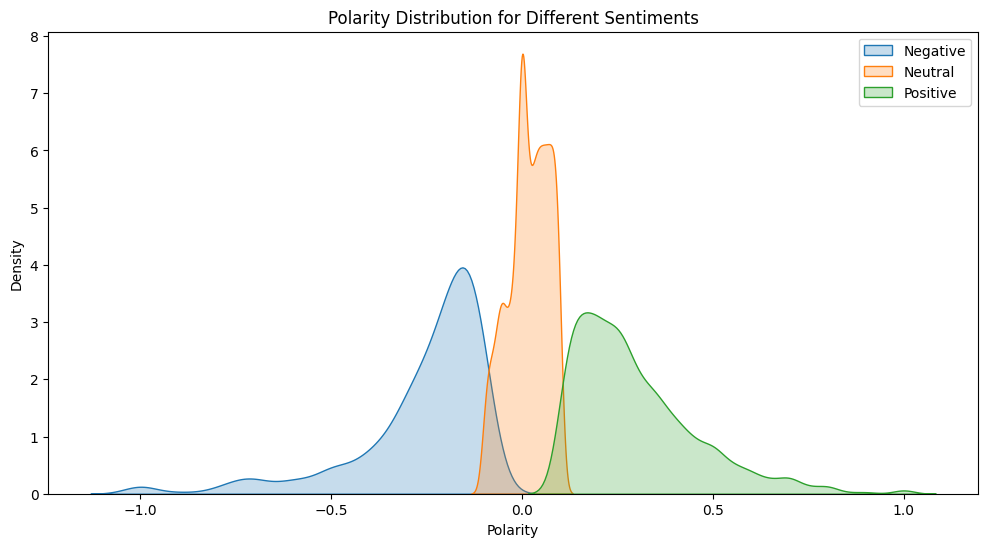

In [9]:
plt.figure(figsize=(12, 6))

sns.kdeplot(df[df['predicted_sentiment'] == "negative"]['polarity'], label='Negative', shade=True)
sns.kdeplot(df[df['predicted_sentiment'] == "neutral"]['polarity'], label='Neutral', shade=True)
sns.kdeplot(df[df['predicted_sentiment'] == "positive"]['polarity'], label='Positive', shade=True)
plt.title('Polarity Distribution for Different Sentiments')
plt.xlabel('Polarity')
plt.ylabel('Density')
plt.legend()
plt.show()




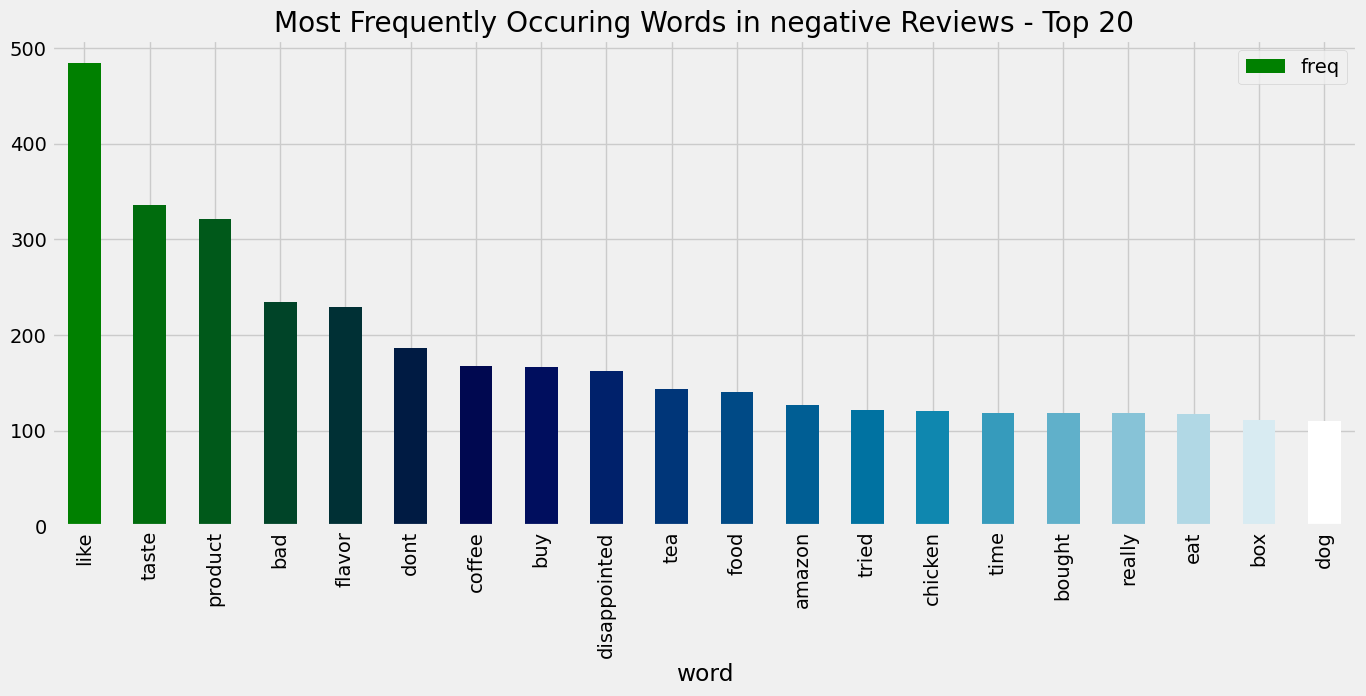

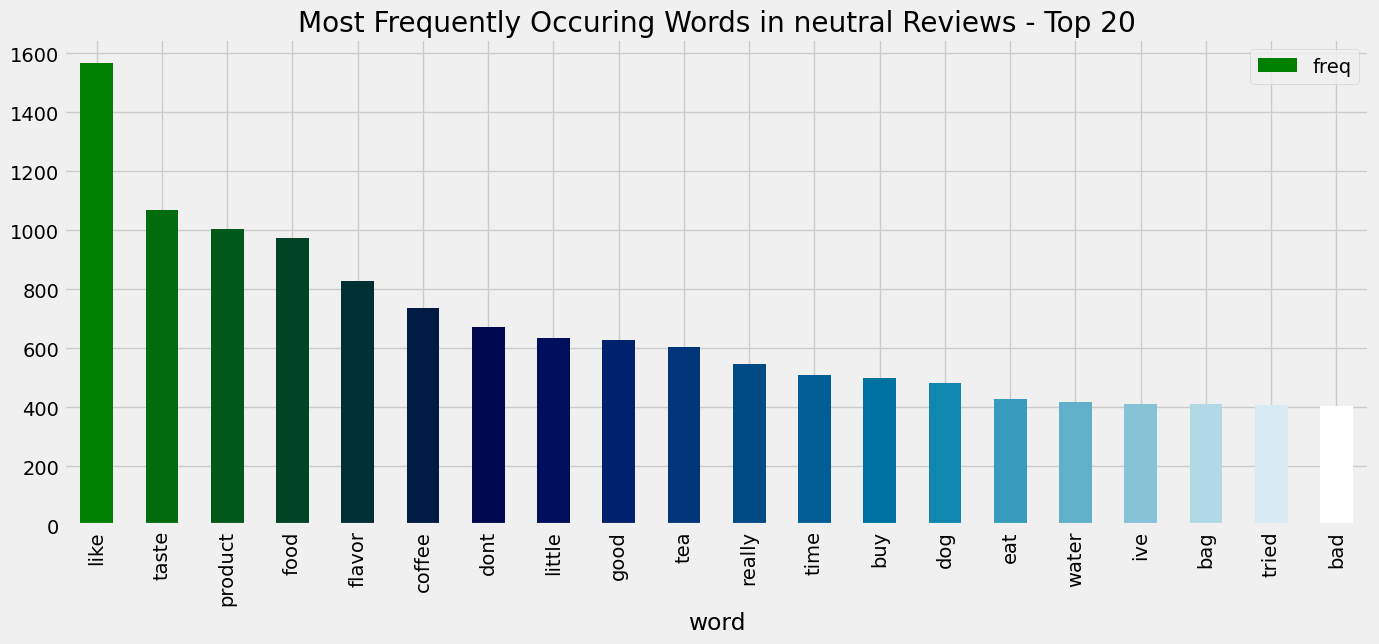

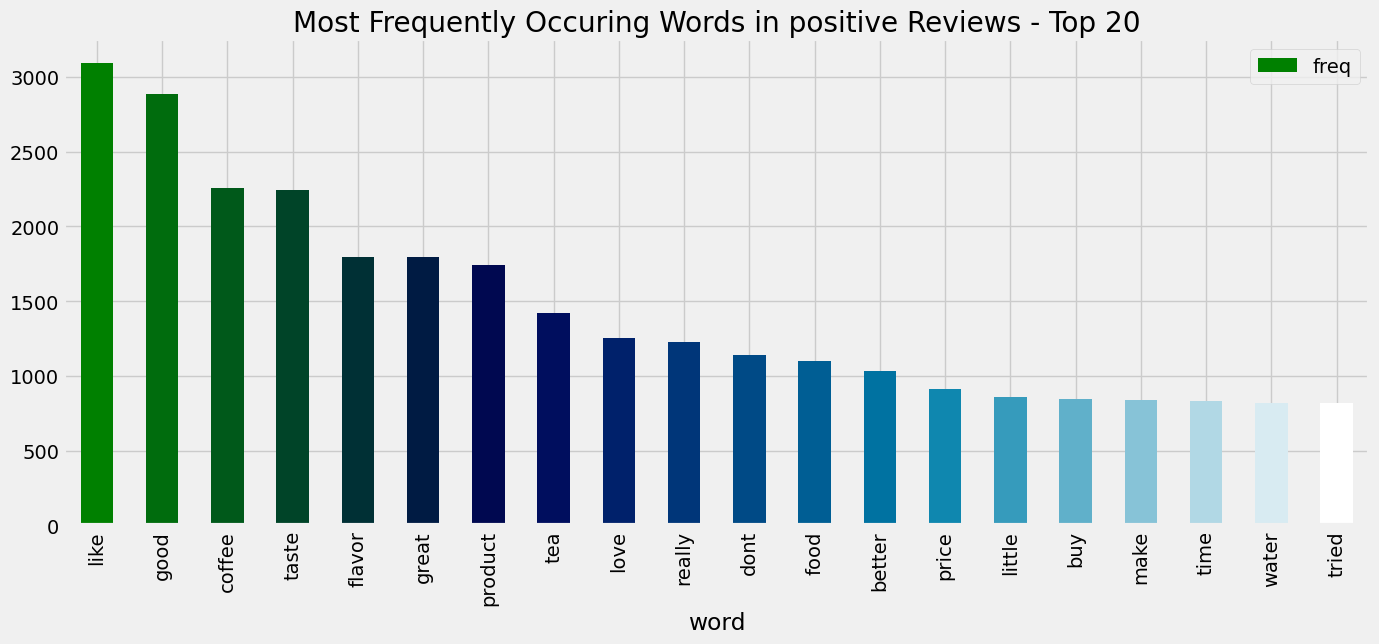

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Assuming df and the 'predicted_sentiment' column are already defined as in your provided code.

def plot_top_words(sentiment):
    # Filter the dataframe by the specified sentiment
    subset = df[df['predicted_sentiment'] == sentiment]

    # If no reviews have this sentiment
    if len(subset) == 0:
        print(f"No reviews found with sentiment: {sentiment}")
        return

    # Create and fit the CountVectorizer
    cv = CountVectorizer(stop_words = 'english')
    words = cv.fit_transform(subset.Text)
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

    # Plotting
    plt.style.use('fivethirtyeight')
    color = plt.cm.ocean(np.linspace(0, 1, 20))
    frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title(f"Most Frequently Occuring Words in {sentiment} Reviews - Top 20")
    plt.show()


# Call the function for each sentiment
plot_top_words("negative")
plot_top_words("neutral")
plot_top_words("positive")


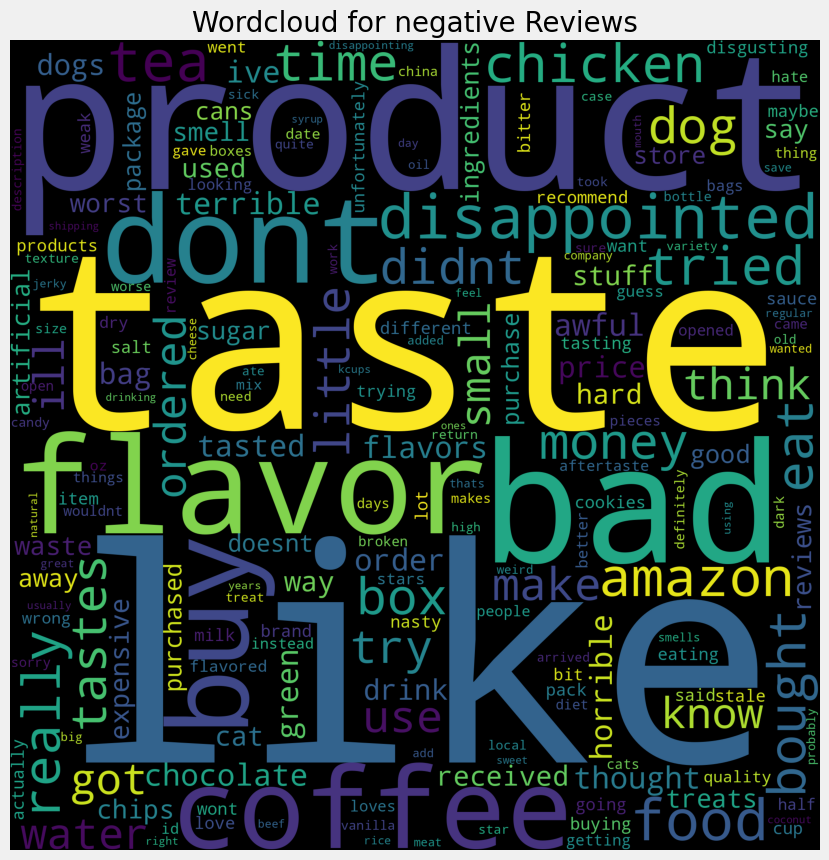

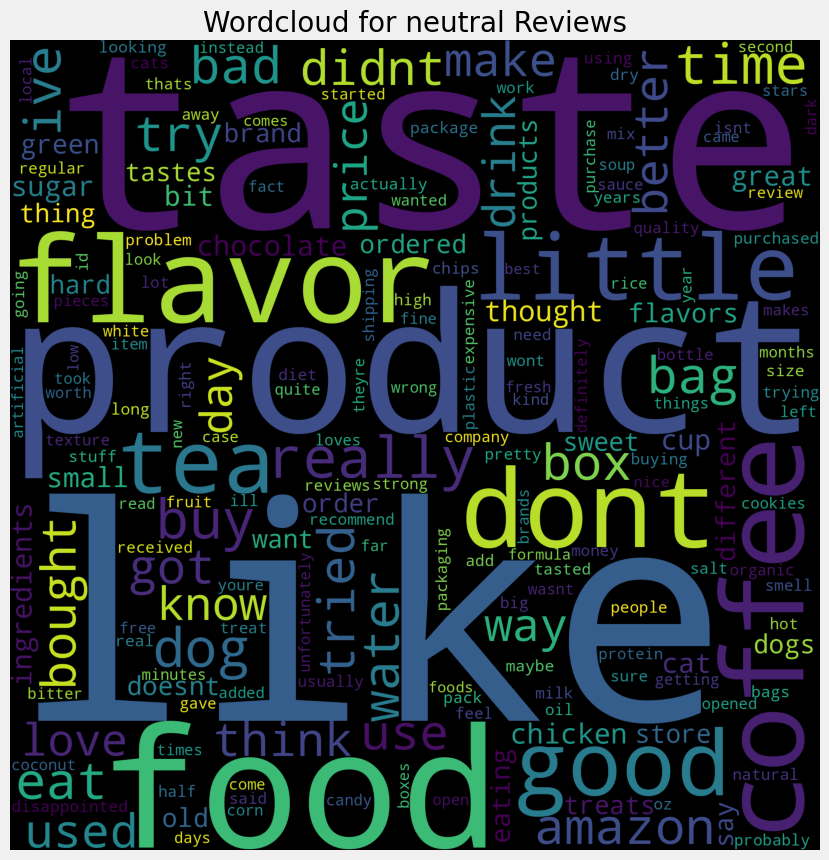

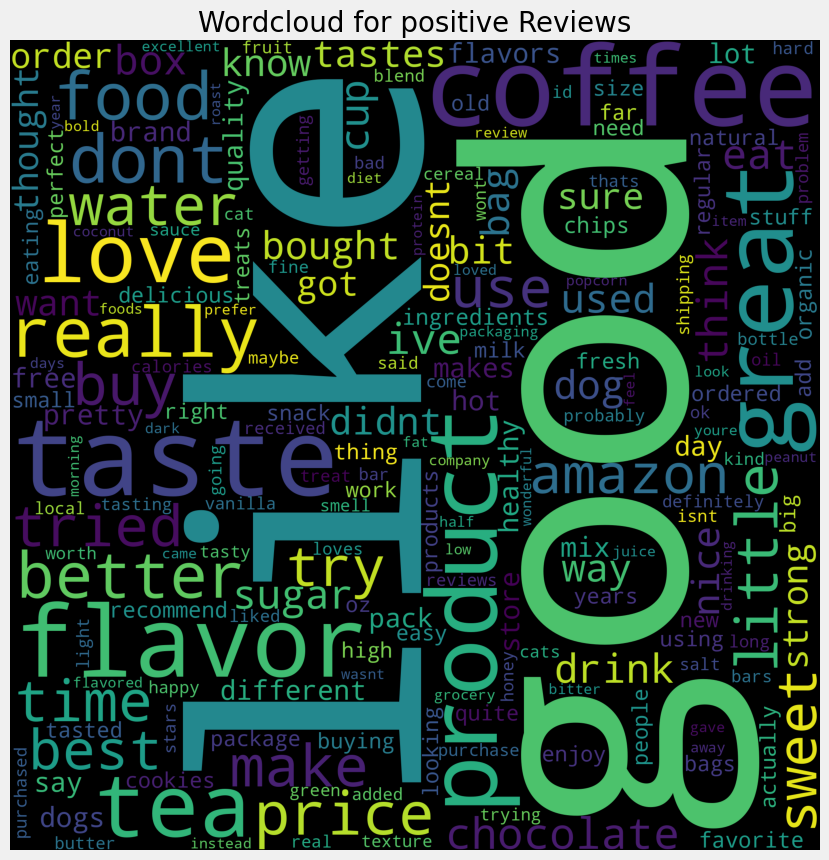

In [11]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment):
    # Filter the dataframe by the specified sentiment
    subset = df[df['predicted_sentiment'] == sentiment]

    # If no reviews have this sentiment
    if len(subset) == 0:
        print(f"No reviews found with sentiment: {sentiment}")
        return

    # Create and fit the CountVectorizer
    cv = CountVectorizer(stop_words = 'english')
    words = cv.fit_transform(subset.Text)
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    # Generate word cloud
    wordcloud = WordCloud(background_color='black', width=2000, height=2000).generate_from_frequencies(dict(words_freq))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(f"Wordcloud for {sentiment} Reviews", fontsize=20)
    plt.show()

# Call the function for each sentiment
plot_wordcloud("negative")
plot_wordcloud("neutral")
plot_wordcloud("positive")


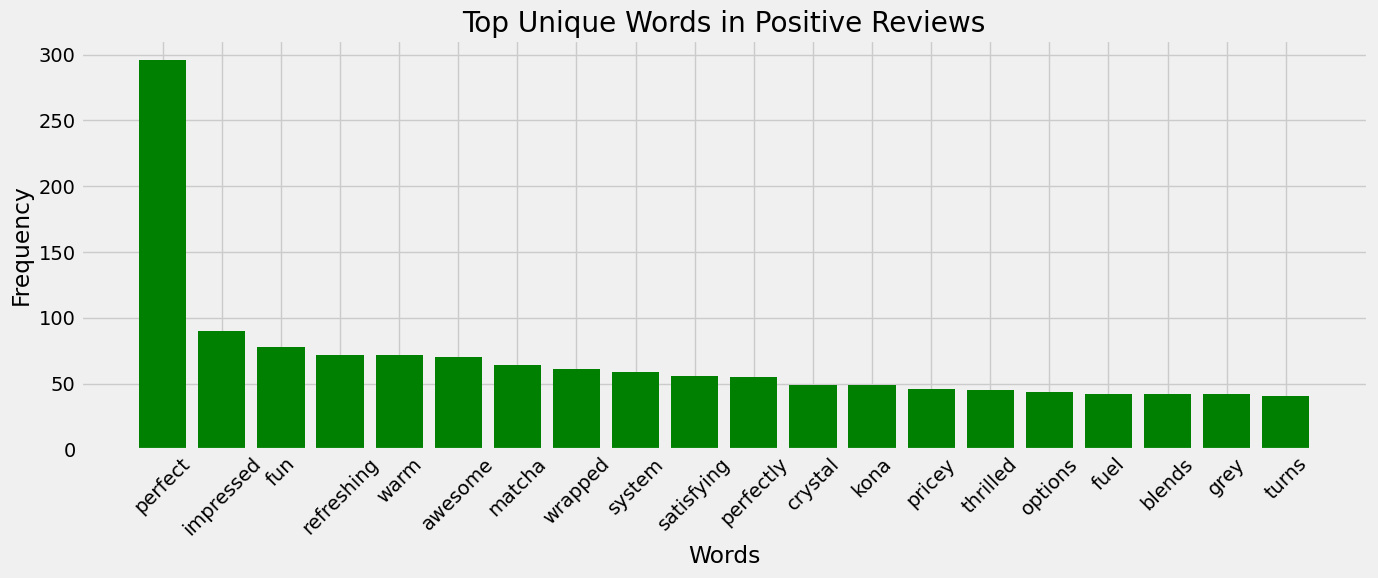

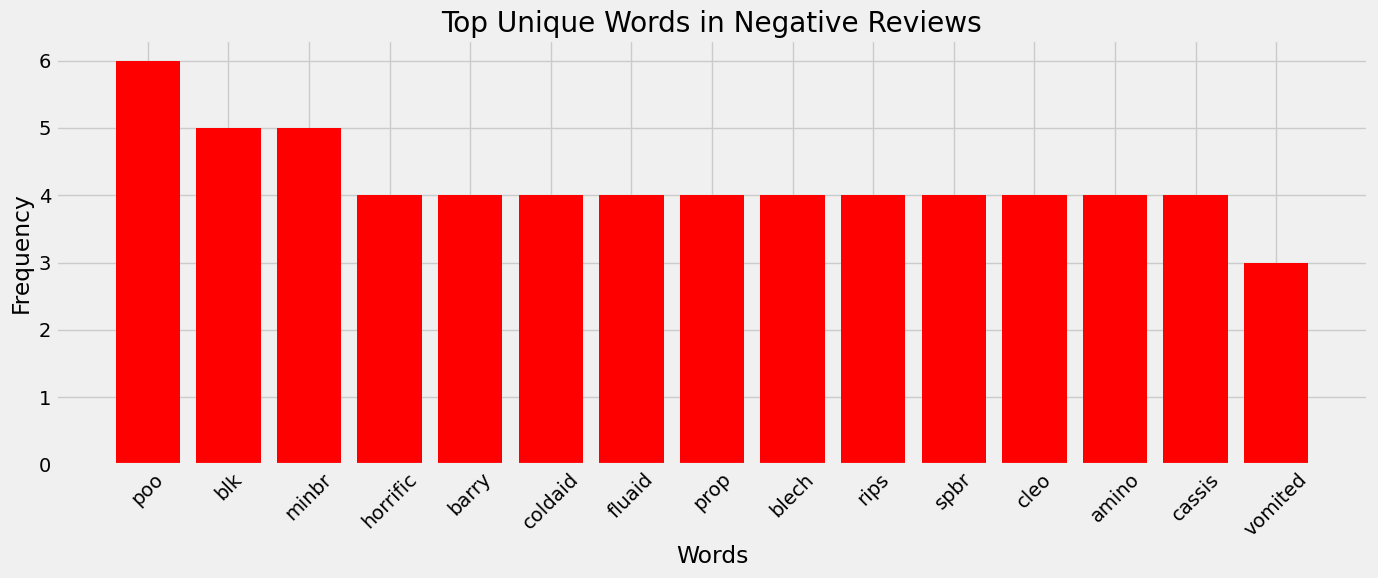

In [21]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def find_and_plot_unique_frequent_words(df):
    # Split positive and negative reviews
    positive_reviews = df[df['predicted_sentiment'] == 'positive']['Text'].str.cat(sep=' ')
    negative_reviews = df[df['predicted_sentiment'] == 'negative']['Text'].str.cat(sep=' ')

    # Tokenize
    positive_words = positive_reviews.split()
    negative_words = negative_reviews.split()

    # Word counts
    positive_word_counts = Counter(positive_words)
    negative_word_counts = Counter(negative_words)

    # Unique words
    positive_unique_words = {word for word in positive_word_counts if word not in negative_word_counts}
    negative_unique_words = {word for word in negative_word_counts if word not in positive_word_counts}

    # Filter top 20 frequent words that are unique
    top_positive_unique = [(word, count) for word, count in positive_word_counts.most_common(1500) if word in positive_unique_words][:20]
    top_negative_unique = [(word, count) for word, count in negative_word_counts.most_common(1500) if word in negative_unique_words][:20]

    # Convert to DataFrame for plotting
    pos_df = pd.DataFrame(top_positive_unique, columns=['word', 'freq'])
    neg_df = pd.DataFrame(top_negative_unique, columns=['word', 'freq'])

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(pos_df['word'], pos_df['freq'], color='green')
    plt.xticks(rotation=45)
    plt.title("Top Unique Words in Positive Reviews")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.bar(neg_df['word'], neg_df['freq'], color='red')
    plt.xticks(rotation=45)
    plt.title("Top Unique Words in Negative Reviews")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Usage
find_and_plot_unique_frequent_words(df)


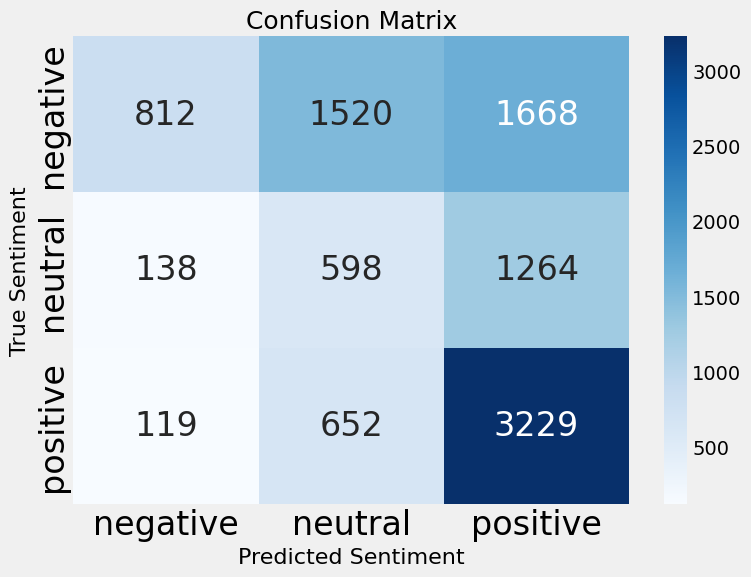

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Map the 'Score' column to ground truth sentiment labels
def map_score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the mapping
df['ground_truth'] = df['Score'].apply(map_score_to_sentiment)

# Extract labels
y_true = df['ground_truth'].astype(str)
y_pred = df['predicted_sentiment'].astype(str)
labels = ['negative', 'neutral', 'positive']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix with larger font sizes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 24})  # Font size of numbers inside the boxes

plt.xlabel('Predicted Sentiment', fontsize=16)
plt.ylabel('True Sentiment', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.show()
